## 5. PCA

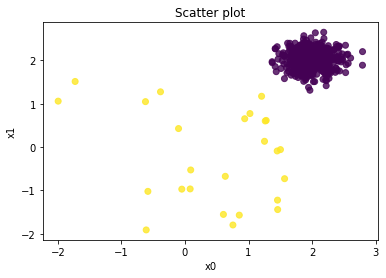

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 6      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train, 
    n_test=n_test, 
    n_features= n_features, 
    contamination=contamination, 
    random_state=123)

# Make the 2d numpy array a pandas dataframe for each manipulation 
X_train_pd = pd.DataFrame(X_train)
    
# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

### Step 1: Build the model

In [31]:
from pyod.models.pca import PCA
pca = PCA(contamination=0.05) 
pca.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = pca.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = pca.decision_scores_  # .decision_scores_ yields the raw outlier scores for the training data
y_train_scores = pca.decision_function(X_train) # You also can use .decision_function()
y_train_pred = pca.predict(X_train) # You also can use .decision_function()

y_test_scores = pca.decision_function(X_test) # You also can use .decision_function()
y_test_pred = pca.predict(X_test) # You also can use .decision_function()

In [15]:
pca.get_params()

{'contamination': 0.05,
 'copy': True,
 'iterated_power': 'auto',
 'n_components': None,
 'n_selected_components': None,
 'random_state': None,
 'standardization': True,
 'svd_solver': 'auto',
 'tol': 0.0,
 'weighted': True,
 'whiten': False}

In [16]:
[pca.explained_variance_,
pca.explained_variance_ratio_]

[array([4.13739583, 0.55186189, 0.38712658, 0.34746491, 0.31134247,
        0.27683236]),
 array([0.68818684, 0.09179303, 0.06439205, 0.057795  , 0.05178663,
        0.04604645])]

### Step 2: Determine the threshold

In [32]:
print("The threshold for the defined comtanimation rate:" , pca.threshold_)

The threshold for the defined comtanimation rate: 219.77196222591996


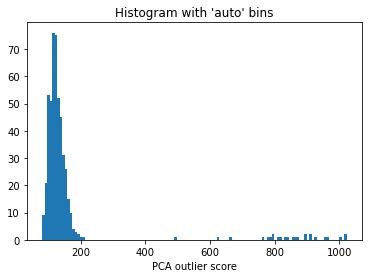

In [20]:
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('PCA outlier score')
plt.show()

In [21]:
threshold = pca.threshold_
threshold

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,2.00,2.01,2.01,1.99,2.01,1.98,124.59
1,Outlier,25,5.0,0.45,-0.21,-0.47,-0.23,-0.03,-0.06,844.33


In [28]:
Actual_pred = pd.DataFrame({'Actual': y_test, 'Anomaly_Score': y_test_scores})
Actual_pred['Pred'] = np.where(Actual_pred['Anomaly_Score']< threshold,0,1)
pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


### Comparisons between models

In [24]:
########
# HBOS #
########
from pyod.models.hbos import HBOS
n_bins = 50
hbos = HBOS(n_bins=n_bins,contamination=0.05) 
hbos.fit(X_train)
y_train_hbos_scores = hbos.decision_function(X_train)
y_test_hbos_scores = hbos.decision_function(X_test)

########
# ECOD #
########
from pyod.models.ecod import ECOD
clf_name = 'ECOD'
ecod = ECOD(contamination=0.05) 
ecod.fit(X_train)
y_test_ecod_scores = ecod.decision_function(X_test)

########
# PCA  #
########
from pyod.models.pca import PCA
pca = PCA(contamination=0.05) 
pca.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_test_pca_scores = pca.decision_function(X_test) # You also can use .decision_function()

# Thresholds
[ecod.threshold_, hbos.threshold_, pca.threshold_]

[16.320821760780653, 5.563712646460526, 219.77196222591996]

In [33]:
# Put the actual, the HBO score and the ECOD score together
Actual_preds = pd.DataFrame({'Actual': y_test, 
                             'HBO_Score': y_test_hbos_scores, 
                             'ECOD_Score': y_test_ecod_scores, 
                             'PCA_Score': y_test_pca_scores})
Actual_preds['HBOS_pred'] = np.where(Actual_preds['HBO_Score']>hbos.threshold_,1,0)
Actual_preds['ECOD_pred'] = np.where(Actual_preds['ECOD_Score']>ecod.threshold_,1,0)
Actual_preds['PCA_pred'] = np.where(Actual_preds['PCA_Score']>pca.threshold_,1,0)
Actual_preds.head()

,Actual,HBO_Score,ECOD_Score,PCA_Score,HBOS_pred,ECOD_pred,PCA_pred
0,0.0,-0.480781,9.547880,135.864318,0,0,0
1,0.0,-1.118669,9.357850,120.636561,0,0,0
2,0.0,-2.436932,7.993147,105.989093,0,0,0
3,0.0,-0.540879,9.336068,135.381702,0,0,0
4,0.0,-2.092258,8.857059,128.305261,0,0,0


In [26]:
pd.crosstab(Actual_preds['HBOS_pred'],Actual_preds['PCA_pred'])

PCA_pred,0,1
HBOS_pred,,
0,474,0
1,1,25


In [27]:
pd.crosstab(Actual_preds['ECOD_pred'],Actual_preds['PCA_pred'])

PCA_pred,0,1
ECOD_pred,,
0,473,0
1,2,25
